<a href="https://colab.research.google.com/github/jvictorferreira3301/LPTP_Analyzer/blob/main/LPTP_Analyzer.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" style="height: 27px; margin-right: 10px;"/>

## Análise Estatística da Sincronização de Tempo em Redes Locais Usando LinuxPTP

A sincronização precisa de tempo em redes de computadores é fundamental para diversas aplicações, incluindo redes industriais, telecomunicações e data centers. Neste trabalho, utilizamos o [LinuxPTP](https://linuxptp.sourceforge.net/), uma implementação do [**Precision Time Protocol (PTP)**](https://endruntechnologies.com/pdf/PTP-1588.pdf), para simular e analisar a sincronização de tempo entre diferentes nós de uma rede. O LinuxPTP oferece uma maneira robusta de sincronizar relógios em diferentes dispositivos numa LAN, permitindo atingir precisões na ordem de microssegundos ou até nanosegundos, dependendo das condições da rede e do hardware disponível.

A análise deste trabalho é feita utilizando **Estatística Descritiva e Inferencial**, com a aplicação de **testes de hipóteses** para avaliar o comportamento da sincronização em diferentes cenários. Para isso, configuramos nós em uma rede local que atuam como mestres e escravos PTP, e coletamos dados de _**Time offset**_ durante a sincronização.

Os principais objetivos deste trabalho incluem:

- **$I.$ Testar Timestamping em Software vs. Hardware**: Comparar a eficácia da sincronização utilizando **timestamping em software** e **timestamping em hardware**.

- **Avaliar a Qualidade da Sincronização**: Examinar se o **offset** entre o mestre e o escravo se mantém próximo de zero em diferentes condições de rede.

- **Comparar Topologias de Sincronização**: Verificar a eficácia de diferentes configurações, como topologias **mestre-escravo** simples e aquelas que envolvem **_Transparent Clocks_** ou **_Boundary Clocks_**.



## Ambiente de testes

Para este estudo, utilizamos 3 computadores cuja as especificações são descritas na tabela abaixo:

| Especificação      | PC 1 (jv3301)                | PC 2 (Vostro-3470)               | PC 3 (lasse100)                      |
|--------------------|---------------------------------|--------------------------------------------|-----------------------------------------|
| OS                 | Ubuntu 22.04.5 LTS        | Ubuntu 22.04.4 LTS                   | Ubuntu 18.04.4 LTS                |
| Kernel             | 6.8.0-45-generic                | 6.5.0-35-generic                           | 4.15.0-213-generic                      |
| NIC                 | Intel X550-T2 PCI-E X4         | Intel X550-T2 PCI-E X4                     | Intel X550-T2 PCI-E X4      |
| CPU                | Intel i5-7600 (4) 4.1GHz     | Intel i5-9400 (6) 4.1GHz                | Intel i7-5930K (12) 3.7GHz          |
| GPU                | Intel HD Graphics 630           | Intel HD Graphics 630  | AMD Radeon HD 7770/8760                 |
| Memory             | 8GB                 | 16GB                           | 64GB                        |

**Tabela 1** - Especificações dos computadores utilizados nos testes.

Os dados são coletados diretamente dos logs do **ptp4l**, a ferramenta do LinuxPTP que executa a sincronização.


## Linux PTP

O [LinuxPTP](https://linuxptp.sourceforge.net/) é uma implementação do Precision Time Protocol (PTP), conforme definido pelo padrão [**IEEE 1588**](https://endruntechnologies.com/pdf/PTP-1588.pdf). O PTP é um protocolo de rede utilizado para sincronizar relógios em sistemas de computadores distribuídos através de uma rede local (LAN).

Componentes Principais:

- ptp4l: O daemon principal do LinuxPTP, responsável por implementar o protocolo PTP e gerenciar a sincronização de tempo entre os dispositivos.
- phc2sys: Uma ferramenta auxiliar que sincroniza o relógio de hardware do PTP (PHC) com o relógio do sistema, garantindo que ambos permaneçam alinhados.

<div style="text-align: center;">
    <div style="text-align: center;">
        <img src="./assets/HS.png" width="840" height="480" allow="autoplay">
        <figcaption> Fig. 1 - Diagrama do LinuxPTP </figcaption>
    </div>

## $I$. Software Timestamping Vs. Hardware Timestamping

Para a primeira análise inferencial vamos comparar o sincronismo utilizando Software Timestamping Vs. Hardware Timestamping. 

- Software timestamping é o processo de marcar o tempo de eventos diretamente no software. Isso geralmente é feito no nível da aplicação ou do sistema operacional. A precisão do timestamp depende da carga do sistema e da latência do software, o que pode introduzir variações e atrasos.

- Hardware timestamping, por outro lado, envolve a marcação de tempo diretamente no hardware de rede, como em placas de rede (NICs). Isso permite uma precisão muito maior, pois os timestamps são gerados no momento exato em que os pacotes são enviados ou recebidos, minimizando a latência e a variação introduzida pelo software.

Nas imagens abaixo podemos ver onde cada tipo de timestamping atua na camada de pilhas e a topologia usada para essa primeira comparação: 

<div style="display: flex; justify-content: center;">
    <figure style="margin-right: 10px; text-align: center;">
        <img src="./assets/ptp-hardware-software-based-timestamp.png" width="500" height="480" style="display: flex; margin:0">
        <figcaption>Hardware Vs. Software Timestamping. <a href="https://networklessons.com/cisco/ccnp-encor-350-401/introduction-to-precision-time-protocol-ptp#:~:text=PTP%20works%20best%20when%20your%20hardware%20supports%20it.%20A%20NIC%20with%20PTP%20support%20has%20its%20own%20onboard%20clock%2C%20which%20is%20used%20to%20timestamp%20messages.%20You%20can%20run%20PTP%20in%20software%20without%20hardware%20support%2C%20but%20your%20OS%20will%20have%20to%20take%20care%20of%20timestamping.%20This%20negatively%20affects%20delay.">Fonte</a></figcaption>
    </figure>
    <figure style="text-align: center;">
        <img src="./assets/topo1.png" width="500" height="480" tyle="display: flex; margin:10px">
        <figcaption>Topologia do teste 1.</figcaption>
    </figure>
</div>

A segunda imagem ilustra uma topologia de rede ponto a ponto, composta por dois computadores: PC 1 (servidor "Master") e PC 2 (servidor "Slave"). Esses dispositivos estão conectados diretamente por um link físico, representado pela linha azul, sem outros dispositivos de rede intermediários. Ambos os PCs possuem placas de interface de rede Intel X550-T2 PCI-E X4, que são usadas para estabelecer a comunicação direta.

Para realizar os testes de sincronização de tempo, configuramos o PC 1 como o mestre executando o comando `ptp4l`, enquanto o PC 2 foi definido como escravo também utilizando `ptp4l`. Em ambos os PCs, o log da execução foi redirecionado para um arquivo de texto, registrando dados por um período de 5 minutos. 

O período de coleta de dados foi relativamente curto, pois, como se trata de uma conexão ponto a ponto sem tráfego de fundo ("background traffic"), acreditamos que a sincronização seguirá uma tendência constante, devido à ausência de interferências externas ou congestionamento que poderiam introduzir variações significativas.

Fizemms esses mesmos passos testando ambas as formas de timestamping.

Abaixo, realizamos o carregamento e processamento dos logs de PTP para extrair informações de time offset e frequency offset, a fim de armazenar esses dados em DataFrames para posterior análise e visualização.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from src.log_processing import process_log_file
from src.plotting import plot_graphs, plot_acf_log
import numpy as np
from scipy.stats import ttest_ind, shapiro, mannwhitneyu, probplot


# Padroes de time e freq
offset_pattern = r'ptp4l\[(\d+\.\d+)\]: master offset\s+(-?\d+)'
freq_pattern = r'ptp4l\[(\d+\.\d+)\]: master offset\s+-?\d+ s2 freq\s+(-?\d+)'

log_files1 = ['logs/Soft.txt', 'logs/Hard.txt'] # Arquivos de texto contendo o log extraido do ptp4l.

# Soft.txt -> log da sincronização usando software timestamping.
# Hard.txt -> log da sincronização usando hardware timestamping.

dataframes1 = {}

for log_file in log_files1:
    dataframes1[log_file] = process_log_file(log_file, offset_pattern, freq_pattern)

Dados a leitura e o processamento, agora podemos visualizar os dados de Software e Hardware timestamping 

- ### Dados do sincronismo usando software timestamping



In [15]:
df_s_log = dataframes1['logs/Soft.txt'] # dataframe da sincronização usando software timestamping.
df_s_log.describe()

,elapsed_time,offset,frequency,seconds
count,1797.000000,1797.000000,0.0,1797.000000
mean,3013.691663,-2325.723984,NaN,898.060663
std,518.928741,16514.015166,NaN,518.928741
min,2115.631000,-87897.000000,NaN,0.000000
25%,2564.661000,-7507.000000,NaN,449.030000
50%,3013.692000,-527.000000,NaN,898.061000
75%,3462.722000,4962.000000,NaN,1347.091000
max,3911.753000,73373.000000,NaN,1796.122000


- ### Dados do sincronismo usando hardware timestamping

In [16]:
df_h_log = dataframes1['logs/Hard.txt'] # dataframe da sincronização usando hardware timestamping.
df_h_log.describe()

,elapsed_time,offset,frequency,seconds
count,1822.000000,1822.000000,1.0,1822.000000
mean,4940.156861,0.781010,-3226.0,910.562861
std,526.147119,453.687744,NaN,526.147119
min,4029.594000,-12749.000000,-3226.0,0.000000
25%,4484.875000,-132.000000,-3226.0,455.281000
50%,4940.157000,0.000000,-3226.0,910.563000
75%,5395.438000,125.750000,-3226.0,1365.844000
max,5850.720000,11990.000000,-3226.0,1821.126000


- ### Filtragem e tratamento de Dados

    - **Subamostragem:** Em séries temporais, como os dados de **offset** coletados no experimento de sincronização de tempo com **LinuxPTP**, pode ocorrer **autocorrelação** entre os valores. A autocorrelação indica que os valores consecutivos de uma série temporal não são independentes, ou seja, o valor atual está correlacionado com valores passados. No entanto, muitos testes de hipótese, assumem que as observações são independentes.
    
        A presença de autocorrelação pode invalidar o uso desses testes, pois viola o pressuposto de independência. Especificamente, a autocorrelação pode subestimar a variância real dos dados, levando a um aumento da taxa de erros do tipo falso positivo e introduzir um viés nos resultados, comprometendo a validade do teste de hipótese.

        Para lidar com essa questão, aplicamos a técnica de **subamostragem**, que consiste em selecionar um subconjunto dos dados originais, espaçando as observações no tempo. No nosso caso, optamos por pegar uma amostra a cada 5 observações, o que diminui a autocorrelação entre os dados, aproximando as observações de um comportamento mais independente.

        A **subamostragem** reduz a dependência entre os valores consecutivos da série temporal, preservando a validade dos testes de hipótese que assumem independência. Com isso, podemos garantir que as conclusões obtidas a partir dos testes sejam mais robustas e confiáveis.
    

    
    - **Remoção de outliers:** Durante a sincronização, observamos que os primeiros momentos são dedicados à estabilização das medidas. Como resultado, as primeiras linhas do log fornecem dados menos precisos, que podem ser considerados outliers. Esses outliers podem prejudicar a visualização e análise dos dados gerais. Portanto, é necessário remover esses outliers na célula de código abaixo:


In [17]:
# Função para remover outliers usando o método IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Selecionar os DataFrames
df_h_log = dataframes1['logs/Hard.txt']
df_s_log = dataframes1['logs/Soft.txt']

# Realizar a subamostragem (selecionar cada 5º valor)
df_h_log = df_h_log.iloc[::5]
df_s_log = df_s_log.iloc[::5]

# Remover outliers da coluna 'offset'
df_h_log = remove_outliers(df_h_log, 'offset')
df_s_log = remove_outliers(df_s_log, 'offset')

# Atualizar o DataFrame no dicionário
dataframes1['logs/Hard.txt'] = df_h_log
dataframes1['logs/Soft.txt'] = df_s_log

Abaixo obtemos os dataset ja filtrados.

In [18]:
### Dados do sincronismo usando software timestamping filtarados e subamostrados

df_s_log.describe()

,elapsed_time,offset,frequency,seconds
count,306.000000,306.000000,0.0,306.000000
mean,2991.294706,-284.735294,NaN,875.663706
std,499.495937,9270.269395,NaN,499.495937
min,2135.632000,-25105.000000,NaN,20.001000
25%,2561.911000,-4746.750000,NaN,446.280000
50%,2993.190000,89.500000,NaN,877.559000
75%,3419.469000,4441.000000,NaN,1303.838000
max,3900.752000,21597.000000,NaN,1785.121000


In [19]:
### Dados do sincronismo usando hardware timestamping filtarados e subamostrados

df_h_log.describe()

,elapsed_time,offset,frequency,seconds
count,363.000000,363.000000,0.0,363.000000
mean,4944.133725,-10.253444,NaN,914.539725
std,525.517638,165.395781,NaN,525.517638
min,4034.594000,-520.000000,NaN,5.000000
25%,4492.125500,-140.000000,NaN,462.531500
50%,4944.658000,-15.000000,NaN,915.064000
75%,5397.188500,119.500000,NaN,1367.594500
max,5849.720000,363.000000,NaN,1820.126000


Com os dados já filtrados podemos comparar as duas sincronizações por meio de gráficos:

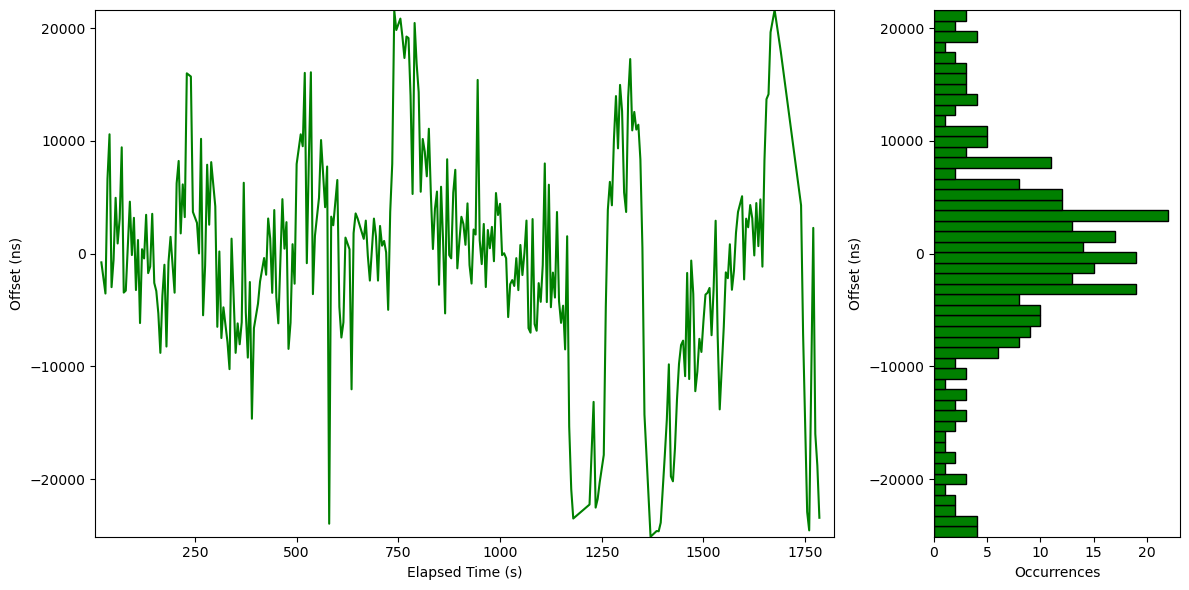

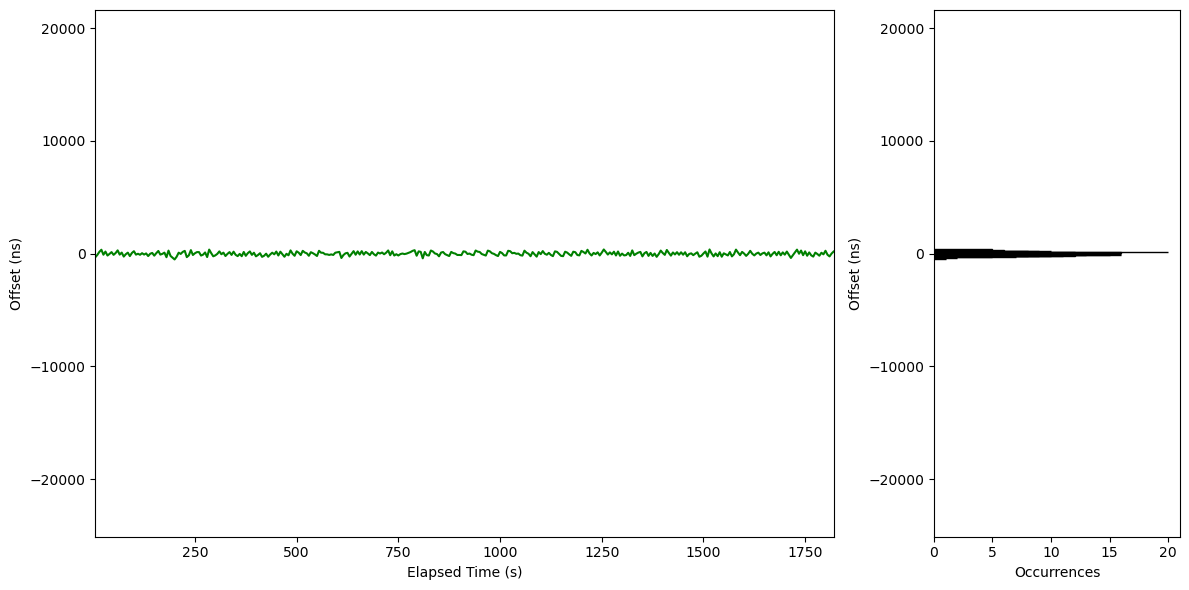

In [20]:
plot_graphs(log_files1, dataframes1, 'Offset (ns)', 'offset_results', 'green')

Como a função que criamos deixa os plots no range do dataset de maior variação a fim de fazer as comparações torna-se inviável visualizar o segundo conjunto de plots, por isso abaixo fazemos o plot isolado. 

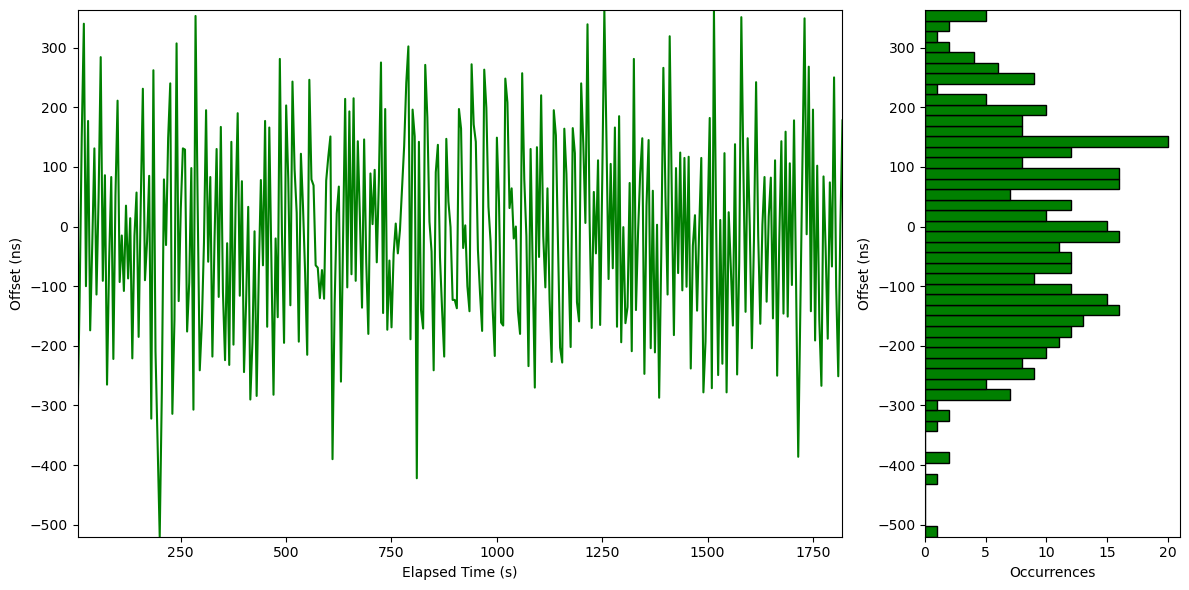

In [21]:
plot_graphs(log_files1, dataframes1, 'Offset (ns)', 'offset_results', 'green','logs/Hard.txt')


Visualmente ja podemos vislumbrar a superioridade de precisão do Hardware Timestamping, para confirmar essa impressão realizaremos a seguir o teste de hipótese, mas antes iremos verificar se os dados em questão seguem uma distribuição nomral para definir qual teste é adequado. 

Hardware timestamping - Shapiro-Wilk test:
Statistic: 0.9896551245452009, p-value: 0.011497200159301564

Software timestamping - Shapiro-Wilk test:
Statistic: 0.9706616661930261, p-value: 6.893395961304657e-06

Os dados de hardware timestamping não são normalmente distribuídos.
Os dados de software timestamping não são normalmente distribuídos.


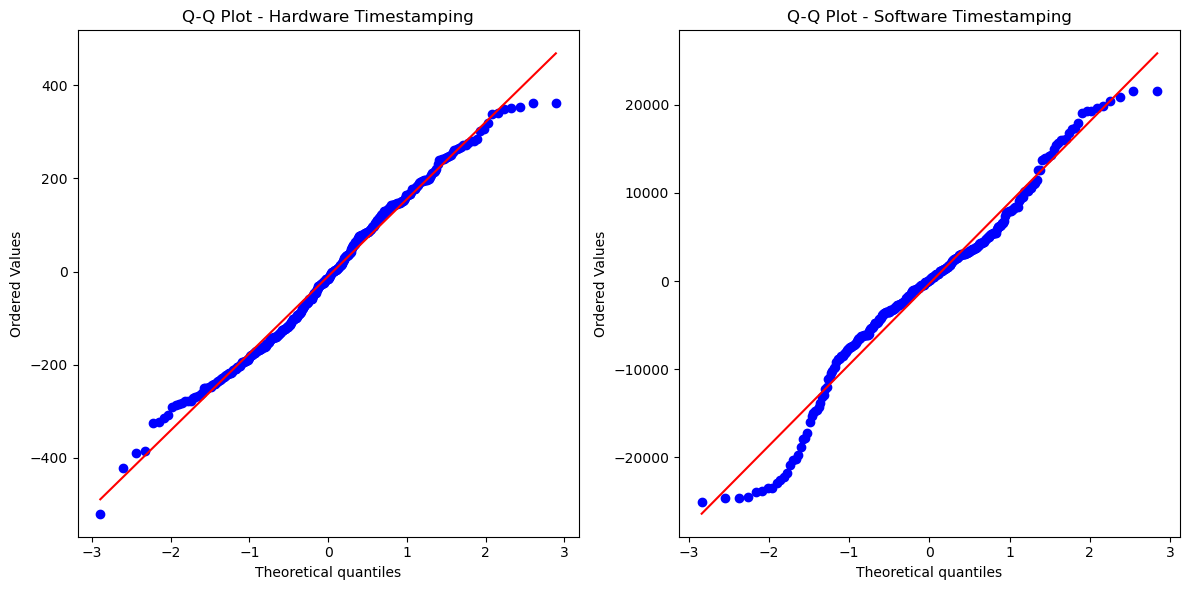

In [22]:
offsets_hardware = df_h_log['offset']
offsets_software = df_s_log['offset']

shapiro_hardware = shapiro(offsets_hardware)
shapiro_software = shapiro(offsets_software)

print("Hardware timestamping - Shapiro-Wilk test:")
print(f"Statistic: {shapiro_hardware.statistic}, p-value: {shapiro_hardware.pvalue}")

print("\nSoftware timestamping - Shapiro-Wilk test:")
print(f"Statistic: {shapiro_software.statistic}, p-value: {shapiro_software.pvalue}")

alpha = 0.05
if shapiro_hardware.pvalue < alpha:
    print("\nOs dados de hardware timestamping não são normalmente distribuídos.")
else:
    print("\nOs dados de hardware timestamping são normalmente distribuídos.")

if shapiro_software.pvalue < alpha:
    print("Os dados de software timestamping não são normalmente distribuídos.")
else:
    print("Os dados de software timestamping são normalmente distribuídos.")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
probplot(offsets_hardware, dist="norm", plot=plt)
plt.title('Q-Q Plot - Hardware Timestamping')

plt.subplot(1, 2, 2)
probplot(offsets_software, dist="norm", plot=plt)
plt.title('Q-Q Plot - Software Timestamping')

plt.tight_layout()
plt.show()

Como os dados não seguem uma distribuição normal e as amostras são independentes optammos por usar o teste não parametrico de Mann-Whitney U com as seguintes hipóteses:

- Hipótese Nula (H0): As duas amostras vêm da mesma distribuição ou têm medianas iguais.

- Hipótese Alternativa (H1): Existe uma diferença significativa entre as duas amostras

In [23]:
u_stat, p_value = mannwhitneyu(offsets_hardware, offsets_software, alternative='two-sided')

print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Rejeitamos a hipótese nula: Há uma diferença significativa na eficácia da sincronização entre hardware e software timestamping.")
else:
    print("Falhamos em rejeitar a hipótese nula: Não há evidência suficiente para afirmar que há uma diferença significativa na eficácia da sincronização entre hardware e software timestamping.")


U-statistic: 54613.0
P-value: 0.7101649157640004
Falhamos em rejeitar a hipótese nula: Não há evidência suficiente para afirmar que há uma diferença significativa na eficácia da sincronização entre hardware e software timestamping.


Como esperado, o teste inferencial corrobou com a impressão descritiva e podemos afirmar que há uma diferença significativa na eficácia da sincronização entre hardware e software timestamping, sendo o hardware timestamping mais eficaz e preciso.

<Figure size 1000x600 with 0 Axes>

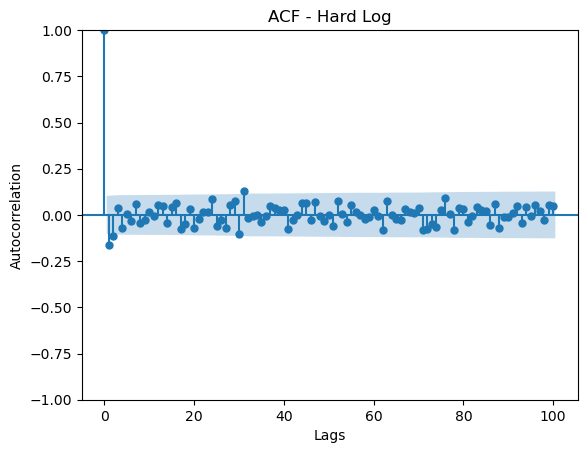

<Figure size 1000x600 with 0 Axes>

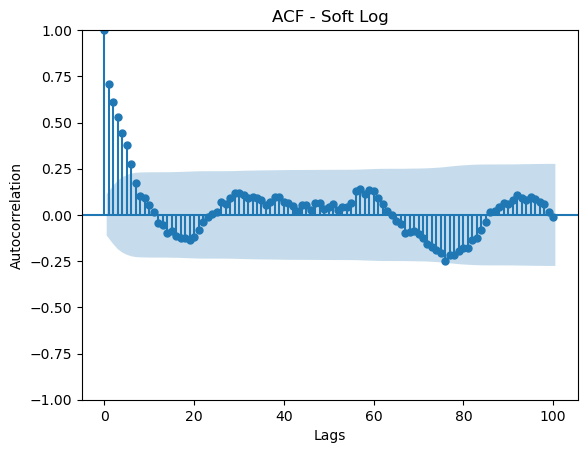

In [24]:
#plot_acf_log(df_h_log, 'offset', 'ACF - Hard Log', lags=100)
#plot_acf_log(df_s_log, 'offset', 'ACF - Soft Log', lags=100)

## $II$. Qualidade da Sincronização

<div style="display: flex; align-items: center;">
    <div style="margin-right: 20px;">
        <p>Para o segundo conjunto de análises vamos comparar o sincronismo em 3 configurações exploradas ao longo dessa seção. Basicamente serão utilizados os 4 tipos de relógios mostrados na figura X ao lado. Abaixo vemos a importação dos logs com os dados de interesse.</p>
    </div>
    <figure style="text-align: center;">
        <img src="./assets/tcbcoc.jpg" width="840" height="480">
        <figcaption>Diferentes tipos de clock PTP. <a href="https://www.cisco.com/c/en/us/td/docs/dcn/aci/apic/5x/system-management-configuration/cisco-apic-system-management-configuration-guide-51x/m-precision-time-protocol.html">Fonte</a></figcaption>
    </figure>
</div>

In [25]:
log_files2 = ['logs/BC.txt', 'logs/TC.txt', 'logs/Switch.txt'] # Arquivos de texto contendo o log extraido do ptp4l.

# BC.txt -> 
# TC.txt -> 
# Switch.txt -> 

dataframes2 = {}

for log_file in log_files2:
    dataframes2[log_file] = process_log_file(log_file, offset_pattern, freq_pattern)

Com os dados importados podemos começar a descrição dos cenários:

#### 2.1 - **PC (PTP-GM) --> Switch PTP Unaware --> PC (PTP Slave):**

<div style="text-align: center;">
        <img src="./assets/topo2.png" width="640" height="480">
        <figcaption>Topologia do teste 2.</figcaption>
    </figure>
</div>

In [26]:
df_Switch_log = dataframes2['logs/Switch.txt']
df_Switch_log.describe()

,elapsed_time,offset,frequency,seconds
count,1347.000000,1347.000000,1346.000000,1347.000000
mean,3633.033696,1.301411,-14871.367013,673.170696
std,389.086452,246.527400,256.711483,389.086452
min,2959.863000,-644.000000,-15657.000000,0.000000
25%,3296.451000,-171.500000,-15050.000000,336.588000
50%,3633.037000,2.000000,-14873.000000,673.174000
75%,3969.616000,181.000000,-14687.000000,1009.753000
max,4306.201000,724.000000,-14044.000000,1346.338000


#### 2.2 - **PC (PTP-GM) --> PC (Boundary clock) --> PC (PTP Slave)**

<div style="text-align: center;">
        <img src="./assets/bc.png" width="740" height="480">
        <figcaption>Topologia do teste 2.</figcaption>
    </figure>
</div>

In [27]:
df_BC_log = dataframes2['logs/BC.txt'] # dataframe da sincronização usando software timestamping.
df_BC_log.describe()

,elapsed_time,offset,frequency,seconds
count,1079.000000,1079.000000,16.000000,1079.000000
mean,605514.949539,0.035218,-1180.625000,598.363539
std,345.839705,431.101192,883.884146,345.839705
min,604916.586000,-3192.000000,-2674.000000,0.000000
25%,605216.031500,-36.000000,-2056.750000,299.445500
50%,605514.870000,1.000000,-1079.500000,598.284000
75%,605814.109000,38.500000,-391.250000,897.523000
max,606113.167000,3099.000000,-64.000000,1196.581000


#### 2.3 - **PC (PTP-GM) --> PC (Transparent clock) --> PC (PTP Slave)**

<div style="text-align: center;">
        <img src="./assets/tc.png" width="740" height="480">
        <figcaption>Topologia do teste 2.</figcaption>
    </figure>
</div>

In [28]:
df_TC_log = dataframes2['logs/TC.txt']
df_TC_log.describe()

,elapsed_time,offset,frequency,seconds
count,1170.000000,1170.000000,1170.000000,1170.000000
mean,564956.646576,0.500855,-3076.726496,526.106576
std,304.137785,17.818410,14.696254,304.137785
min,564430.540000,-45.000000,-3115.000000,0.000000
25%,564693.593000,-9.000000,-3086.000000,263.053000
50%,564956.647000,0.000000,-3076.000000,526.107000
75%,565219.700000,9.000000,-3069.000000,789.160000
max,565482.753000,354.000000,-2893.000000,1052.213000


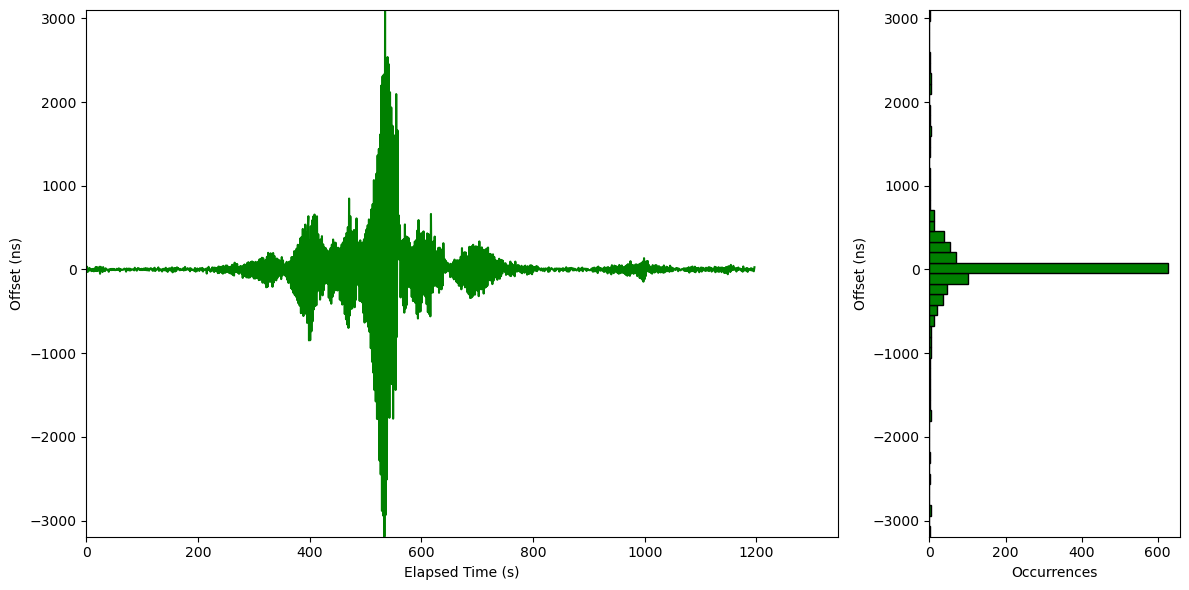

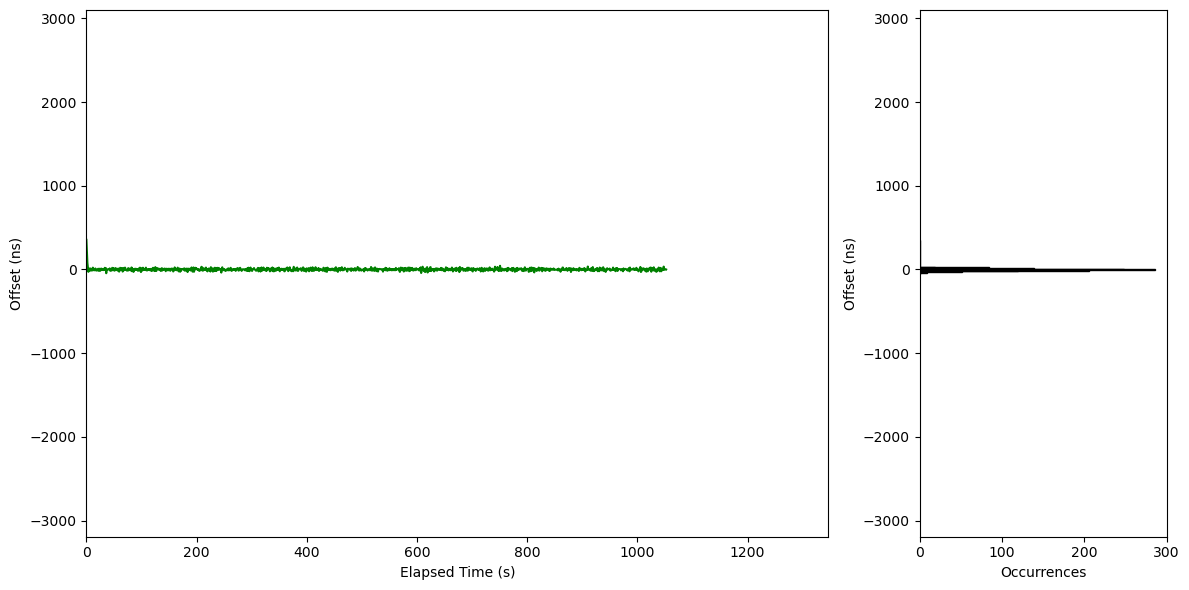

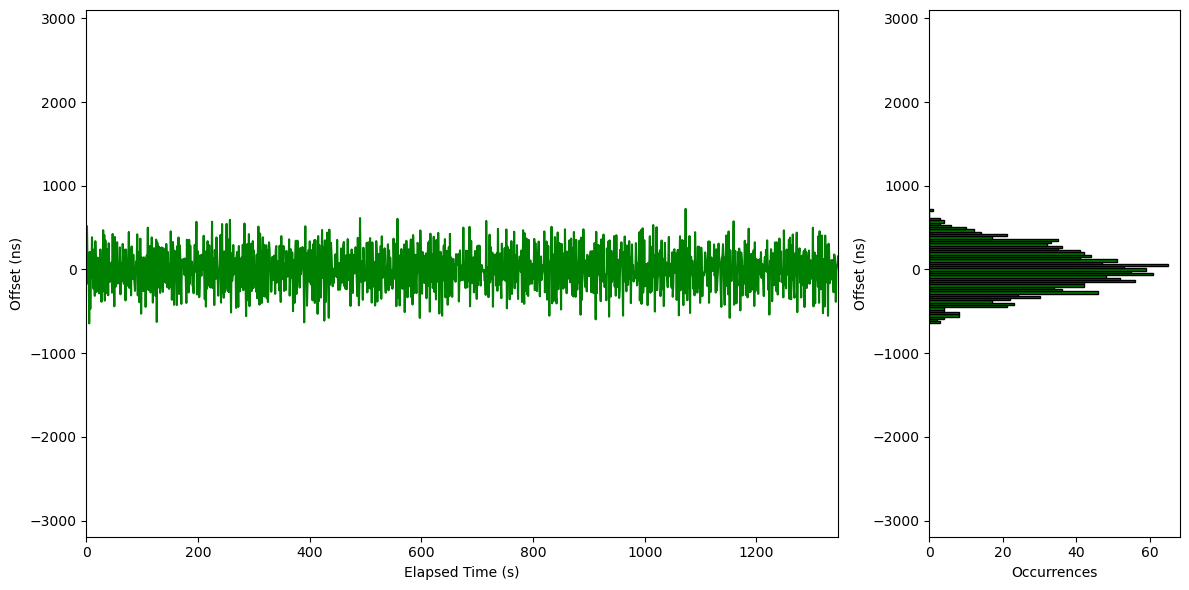

In [29]:
plot_graphs(log_files2, dataframes2, 'Offset (ns)', 'offset_results', 'green')

In [30]:
# Função para plotar o ACF com os lags
def plot_acf_log(df, column, title, lags=50):
    plt.figure(figsize=(10, 6))
    plot_acf(df[column], lags=lags, alpha=0.05)
    plt.title(title)
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.show()

# Selecionar os DataFrames
df_h_log = dataframes1['logs/Hard.txt']
df_s_log = dataframes1['logs/Soft.txt']
df_TC_log = dataframes2['logs/TC.txt']
df_BC_log = dataframes2['logs/BC.txt']
df_Switch_log = dataframes2['logs/Switch.txt']

# Plotar o ACF para cada DataFrame com os lags especificados
plot_acf_log(df_TC_log, 'offset', 'ACF - TC Log', lags=50)
plot_acf_log(df_BC_log, 'offset', 'ACF - BC Log', lags=50)
plot_acf_log(df_Switch_log, 'offset', 'ACF - Switch Log', lags=50)
plot_acf_log(df_h_log, 'offset', 'ACF - Hard Log', lags=50)
plot_acf_log(df_s_log, 'offset', 'ACF - Soft Log', lags=50)

NameError: name 'plot_acf' is not defined

<Figure size 1000x600 with 0 Axes>